## 01. 네트워크 분석 기초

- 사용데이터 :

    - Open Street Map 데이터를 API로 참조해서 사용

- 작성자 : 권도희

- 최종수정일 : 2025.12.10

[수정이력]

- 2025.12.10 최초작성

[참고자료]

Yen (1971), Finding the K shortest loopless paths in a network

Akgün et al. (2000), Finding alternative routes in road networks

Hoogendoorn-Lanser (2005), Modelling travel behaviour

Cardillo et al. (2006), Structural properties of planar street networks

Masucci et al. (2015), Random planar graphs and street networks

Barthelemy (2011), Spatial networks

Taylor et al. (2006), Vulnerability analysis for transportation networks

Derrible & Kennedy (2010), The complexity and robustness of metro networks

### 1. 네트워크의 구조적 분석(Topology)

네트워크를 구성하는 노드, 엣지의 연결상태 등을 통해 네트워크가 가지는 특징들을 판별

- 경로 강제성 : 흐름이 특정 노드·링크를 반드시 거치게 되는가

- 대체 가능성 : 하나가 깨졌을 때 다른 선택지가 구조적으로 존재하는가

- 영향 확산 범위 : 문제가 국지에 머무는가, 전역으로 퍼지는가

- 내부 결속 vs 외부 분리 : 안에서는 잘 돌고, 밖과는 느슨한가

- 역할 이질성 : 노드마다 역할 차이가 큰가, 다 비슷한가

- 공간 제약성 : 연결이 추상적인가, 물리적으로 제한되는가


=> 이러한 구조적 속성들은 도메인 영역에 따라 중요도, 지표산출 혹은 측정 방식, 용어의 사용 등이 다름. 본 자료는 도시공학 영역에 초점을 맞추어 작성


도시공학 관점에서 네트워크의 구조 분석은 : “도시의 구조가 사람들이 어디로 움직일 수밖에 없도록 만드는가”를 계량화하는 작업



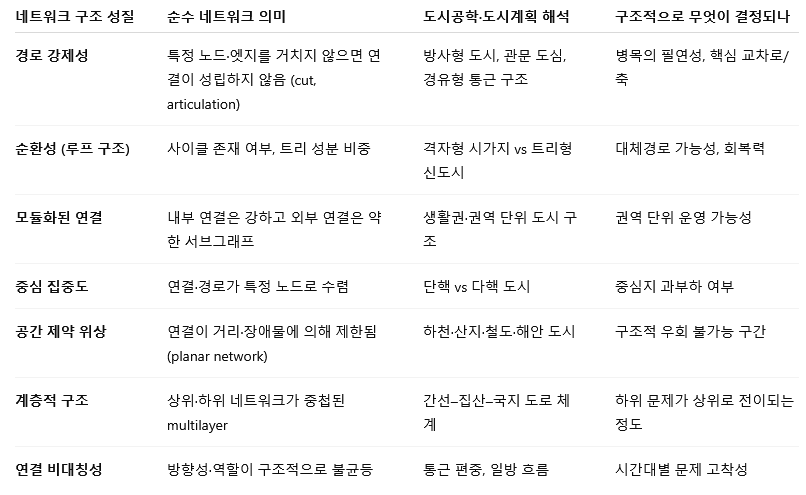

In [99]:
## 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
from collections import defaultdict

## 네트워크데이터 가져오기
import osmnx as ox

## 네트워크 분석용
import networkx as nx

## 클러스터링 등 ML 계산용
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import contextily as ctx

[참고]OSMnx로 도시 네트워크 데이터 가져오기

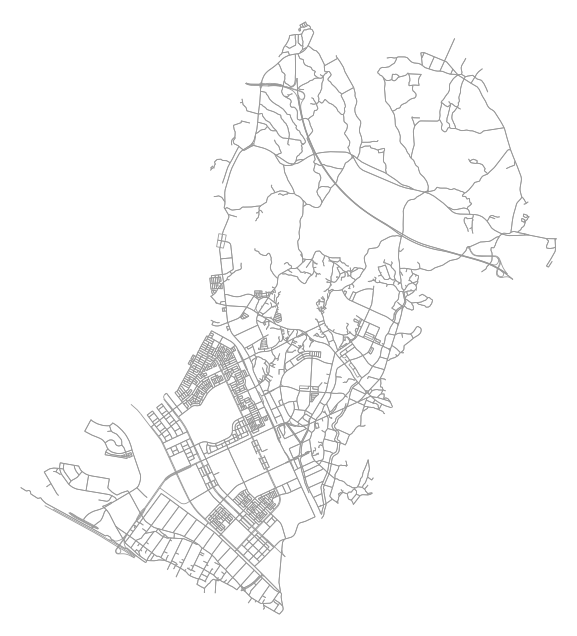

노드 수: 2341
엣지 수: 6456


In [26]:
## [참고]OSMnx로 도시 네트워크 데이터 가져오기

# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Ilsandong-gu, Goyang-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

### 2. 지표별 비교

#### 2-1. 경로강제성

경로 강제성은 두 가지로 정의가능함.

1) 구조적으로 우회로가 없는 경우

2) 비용측면에서 대안경로가 너무 비싼 경우

이를 두 가지 방식으로 계산 가능함

- (A) OD쌍에 대한 경로 강제성


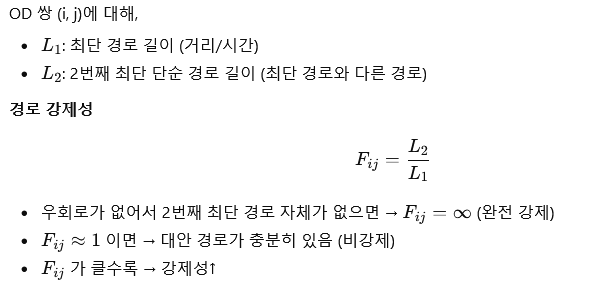

- (B) 엣지 단위 경로 강제성


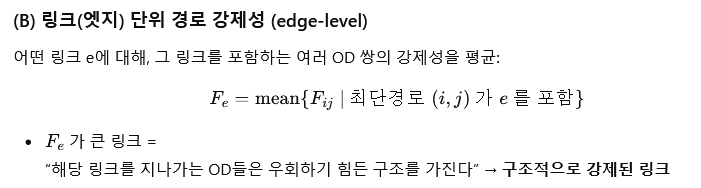

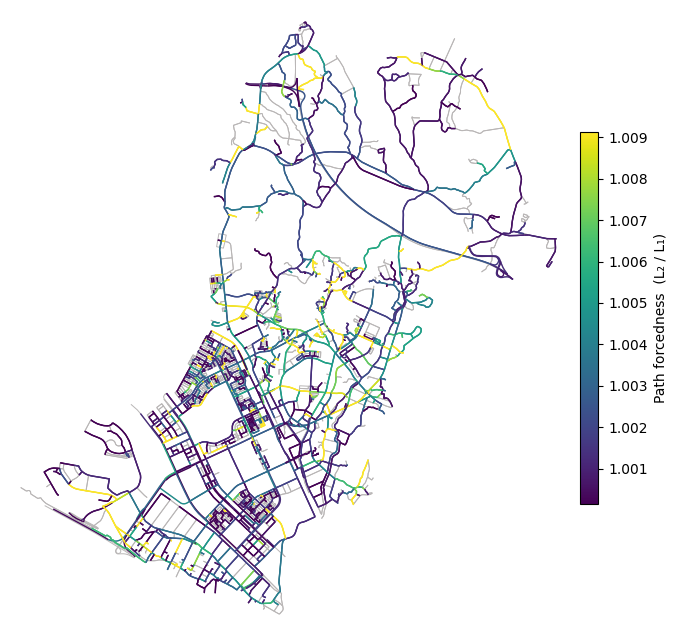

In [ ]:


# 1) 그래프 가져오기 (예: 일산 일부)
place_name = "Ilsandong-gu, Goyang-si, South Korea"
G = ox.graph_from_place(place_name, network_type="drive")

# # 2) 거리 가중치 추가
# G = ox.add_edge_lengths(G)  # edge['length'] 생성

# 3) 작업 편하게 undirected로 변환
# Gu = ox.utils_graph.get_undirected(G)

Gu = nx.DiGraph(G)

fig, ax = ox.plot_graph(
    G,
    edge_color="#b9b6b6",   # 연회색
    edge_linewidth=0.7,
    node_size=0,
    bgcolor="white",
    show=False,
    close=False
)

# 4) OD 샘플 몇 개 선택 (전체 다 하면 너무 무거우니까)
nodes = list(Gu.nodes)
rng = np.random.default_rng(0)
od_pairs = []

for _ in range(1000):  # 우선 100쌍 정도 테스트
    i, j = rng.choice(nodes, 2, replace=False)
    od_pairs.append((i, j))

def pair_forcedness(G, source, target, weight="length", k_paths=2):
    """
    최단, 2번째 최단 경로 기반 경로 강제성 F_ij = L2 / L1
    2번째 경로가 없으면 np.inf 반환
    """
    try:
        # shortest_simple_paths 는 길이 기준으로 정렬된 simple path generator
        gen = nx.shortest_simple_paths(G, source, target, weight=weight)
        # 최단
        path1 = next(gen)
        L1 = nx.path_weight(G, path1, weight)
        # 두 번째 최단
        path2 = next(gen)  # k_paths=2라서 한 번만 더 뽑음
        L2 = nx.path_weight(G, path2, weight)
        return (L2 / L1), path1
    except StopIteration:
        # 2번째 경로가 없음
        return np.inf, path1
    except nx.NetworkXNoPath:
        # 경로 자체가 없음
        return np.nan, []

# 5) edge별 강제성 누적
edge_forcedness =  defaultdict(list)

for s, t in od_pairs:
    F_ij, path = pair_forcedness(Gu, s, t)
    if not path or not np.isfinite(F_ij):
        continue
    # 최단경로에 포함된 edge들에 F_ij 할당
    for u, v in zip(path[:-1], path[1:]):
        e = tuple(sorted((u, v)))   # undirected 기준
        edge_forcedness[e].append(F_ij)

# 6) edge별 평균 경로강제성 계산
for e, vals in edge_forcedness.items():
    if vals:
        edge_forcedness[e] = float(np.mean(vals))
    else:
        edge_forcedness[e] = np.nan

# 7) 시각화를 위해 edge attribute로 붙임
for u, v, k, data in G.edges(keys=True, data=True):
    e = tuple(sorted((u, v)))
    data["forcedness"] = edge_forcedness.get(e, np.nan)

# 이제 forcedness 값을 색깔로 표시하면서 플로팅 가능
# 1) forcedness 값 추출
edge_vals = np.array([
    data.get("forcedness", np.nan)
    for _, _, _, data in G.edges(keys=True, data=True)
])

# 2) 극단값 때문에 색 뭉개지는 거 방지
vmin = np.nanpercentile(edge_vals, 10)
vmax = np.nanpercentile(edge_vals, 90)

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis

# 3) 숫자 → RGBA 색 변환
edge_colors = [
    cmap(norm(v)) if np.isfinite(v) else (0, 0, 0, 0)
    for v in edge_vals
]

# 4) plot
fig, ax = ox.plot_graph(
    G,
    ax=ax,
    edge_color=edge_colors,
    edge_linewidth=1,
    node_size=0,
    show=False,   # 중요
    close=False
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # matplotlib 관례

cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Path forcedness  (L₂ / L₁)", fontsize=10)

plt.show()

[해석]

- 도시 중심부는 격자형, 도로밀집형으로 우회로가 많음. 반면 주요간선도로나 도심지에 인접한 외부 도로일수록 우회로가 적음

#### 2-2. 연결성(connectedness, redundancy)

연결성을 확인하는 방법을 3가지로 구분 가능

1) Bridge여부 : 해당 엣지를 제거했을 때 그래프가 더 많이 쪼개지는 경우를 bridge로 정의

2) 노드 차수(degree)기반 구분 : 노드에 연결된 엣지가 얼마나 많은가? 두 노드의 차수 합이 얼마나 큰가?

    -> 두 노드 차수의 합이 크면 내부 교차로일 가능성이 높음

3) 노드 클러스터링 (Local mesh) : 주변에 작은 순환고리(Cycle)가 얼마나 많은가?

    -> 이웃노드들끼리 얼마나 많이 연결되어있는지를 기반으로 클러스터링


=> Local mesh 방법을 사용


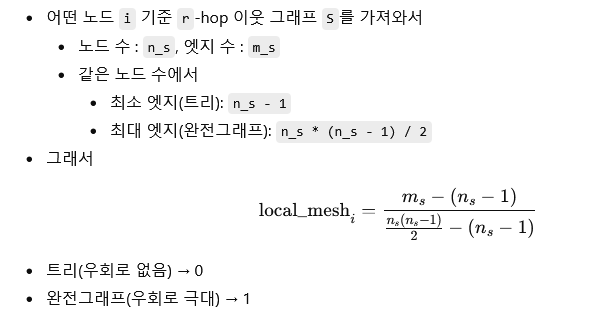

In [42]:
# 0) topology 계산용 simple undirected 그래프
H = nx.Graph(G)   # 방향/중복엣지 제거

def compute_local_mesh(Gu, radius=2):
    local_mesh = {}
    for n in Gu.nodes:
        # n을 중심으로 radius-hop 이웃 subgraph
        S = nx.ego_graph(Gu, n, radius=radius)
        n_s = S.number_of_nodes()
        m_s = S.number_of_edges()
        if n_s <= 2:
            local_mesh[n] = 0.0
            continue

        m_tree = n_s - 1
        m_max = n_s * (n_s - 1) / 2  # 완전그래프
        if m_max == m_tree:
            local_mesh[n] = 0.0
        else:
            local_mesh[n] = (m_s - m_tree) / (m_max - m_tree)

    return local_mesh

local_mesh = compute_local_mesh(H, radius=3)

# 노드 attribute로 저장
nx.set_node_attributes(G, local_mesh, "local_mesh")

In [43]:
# 1) 엣지별 local_mesh : 양 끝 노드 평균
for u, v, k, data in G.edges(keys=True, data=True):
    m_u = G.nodes[u].get("local_mesh", np.nan)
    m_v = G.nodes[v].get("local_mesh", np.nan)
    data["local_mesh_edge"] = np.nanmean([m_u, m_v])

# 2) 엣지별 forcedness를 MultiDiGraph에 붙이기 (이미 edge_forcedness dict 있다고 가정)
for u, v, k, data in G.edges(keys=True, data=True):
    e_und = tuple(sorted((u, v)))
    data["forcedness"] = edge_forcedness.get(e_und, np.nan)

In [ ]:
# 클러스터링 대상 엣지들만 추출
edge_keys = []
X = []
for u, v, k, data in G.edges(keys=True, data=True):
    f = data.get("forcedness", np.nan)
    m = data.get("local_mesh_edge", np.nan)
    if np.isfinite(f) and np.isfinite(m):
        edge_keys.append((u, v, k))
        X.append([f, m])

X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수는 대충 4개 정도부터 시작해보자
k = 4
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 결과를 edge attribute로 저장
for (u, v, kk), lab in zip(edge_keys, labels):
    G[u][v][kk]["cluster"] = int(lab)


C:\Users\user\AppData\Local\Temp\ipykernel_20516\3559614784.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(clusters))


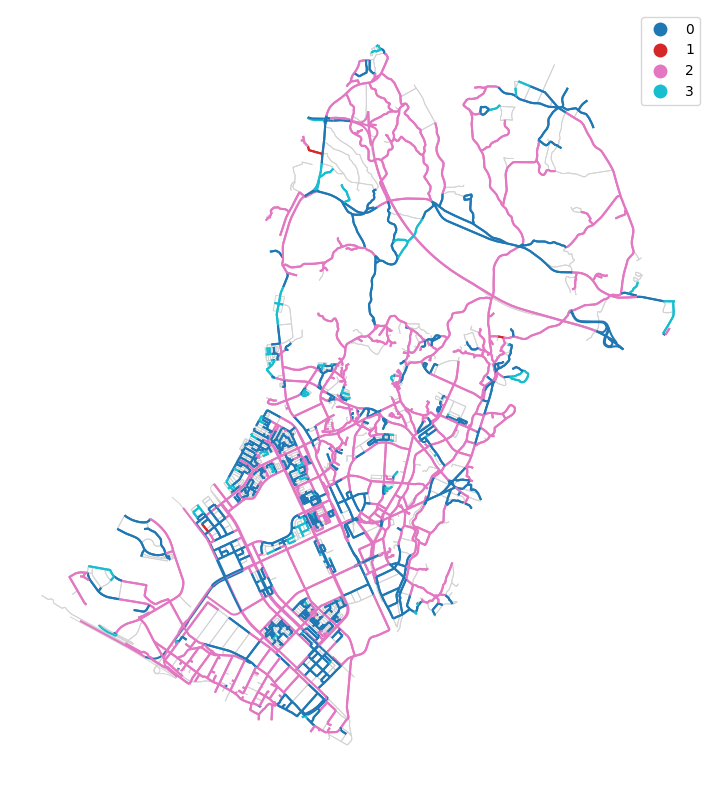

In [66]:
# GeoDataFrame으로 변환
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G, node_geometry=False)

# 클러스터 없거나 NaN인 엣지는 배경 처리
mask_cluster = gdf_edges["cluster"].notna()
gdf_edges["cluster"] = gdf_edges["cluster"].astype("Int64")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# 1) 배경: 모든 엣지를 연한 회색으로
gdf_edges.plot(ax=ax, color="lightgrey", linewidth=0.7)

# 2) overlay: 클러스터된 엣지만 색깔
#   categorical legend를 위해 colormap 수동 생성
clusters = sorted(gdf_edges.loc[mask_cluster, "cluster"].dropna().unique())
cmap = cm.get_cmap("tab10", len(clusters))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(clusters)+1)-0.5, ncolors=len(clusters))

gdf_edges[mask_cluster].plot(
    ax=ax,
    column="cluster",
    linewidth=1.5,
    cmap=cmap,
    norm=norm,
    categorical=True,
    legend=True,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [69]:

# edges GeoDataFrame
_, edges_gdf = ox.graph_to_gdfs(G, node_geometry=False)

# cluster, local_mesh_edge 있는 엣지만
df = edges_gdf[edges_gdf["cluster"].notna()].copy()

# 타입 정리
df["cluster"] = df["cluster"].astype(int)

# 클러스터별 통계
cluster_stats = (
    df.groupby("cluster")["local_mesh_edge"]
      .agg(["count", "mean", "std", "min", "max"])
      .sort_values("mean", ascending=False)
)

print(cluster_stats)

         count      mean       std       min       max
cluster                                               
3          347  0.080755  0.025053  0.060440  0.245238
0         2167  0.039222  0.008272  0.026926  0.059938
1           10  0.037145  0.017132  0.007353  0.052381
2         2400  0.015416  0.007854  0.000000  0.037469


- local mesh는 특정 도로 주변의 국지적 연결 구조가 단일연결인지, 다중 그물망 구조인지를 나타냄. 즉, 연결의 중복성과 견고성을 나타내는 지표

- 주도로는 단일연결로(local mesh 값 낮음 : cluster 2), 골목길은 그리드 및 다중연결로(local mesh 값 높음 : cluster 0)의 결과를 보임

#### 2-3. 중심집중도

네트워크상의 흐름(혹은 경로)이 소수 도로에 얼마나 집중되어 있는가? -> 구조적 취약성/의존성을 확인할 수 있음


중심집중도 지표

1) Edge betweenness centrality : 전체 최단 경로 중 해당 도로를 통과하는 비율

2) Freeman centralization : 최대 edge-betweenness와 나머지 차이의 합

3) Flow-weighted centrality : 수요 기반 경유량


계산이 용이한 Edge betweenness centrality를 비교함

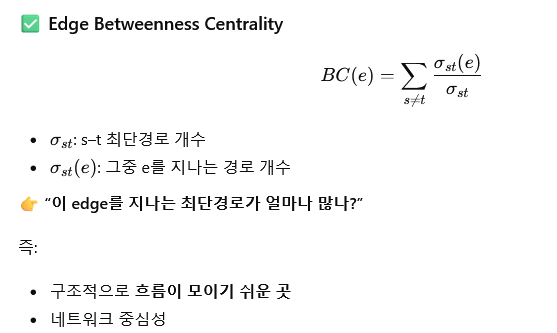

In [82]:
# 1) 그래프 가져오기
place_name = "Ilsandong-gu, Goyang-si, South Korea"
G = ox.graph_from_place(place_name, network_type="drive")  # MultiDiGraph

# OSMnx는 기본적으로 edge['length']를 넣어줌 (추가 설정 필요 X)

# 2) edge betweenness 계산용 간단한 undirected 그래프 만들기
#    - parallel edge, 방향성은 일단 무시하고 구조만 보자
Gu = nx.Graph(G)   # MultiDiGraph -> simple Graph

# 3) edge betweenness 계산 (길이 기준)
bw_dict = nx.edge_betweenness_centrality(Gu, normalized=True, weight="length")
# bw_dict: {(u, v): 값}  (u, v)는 undirected라 (u, v) / (v, u) 동일 취급

# 4) 원래 G(MultiDiGraph)의 edge에 값 붙이기
for u, v, k, data in G.edges(keys=True, data=True):
    key = tuple(sorted((u, v)))  # undirected 키
    data["edge_bw"] = bw_dict.get(key, 0.0)

# 5) GeoDataFrame 변환
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# 혹시라도 없는 컬럼 체크 (디버깅용)
print(edges_gdf.columns)
print(edges_gdf["edge_bw"].describe())

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'reversed',
       'length', 'edge_bw', 'geometry', 'ref', 'tunnel', 'bridge', 'access',
       'junction'],
      dtype='object')
count    6456.000000
mean        0.009990
std         0.018923
min         0.000000
25%         0.000854
50%         0.002384
75%         0.008925
max         0.177086
Name: edge_bw, dtype: float64


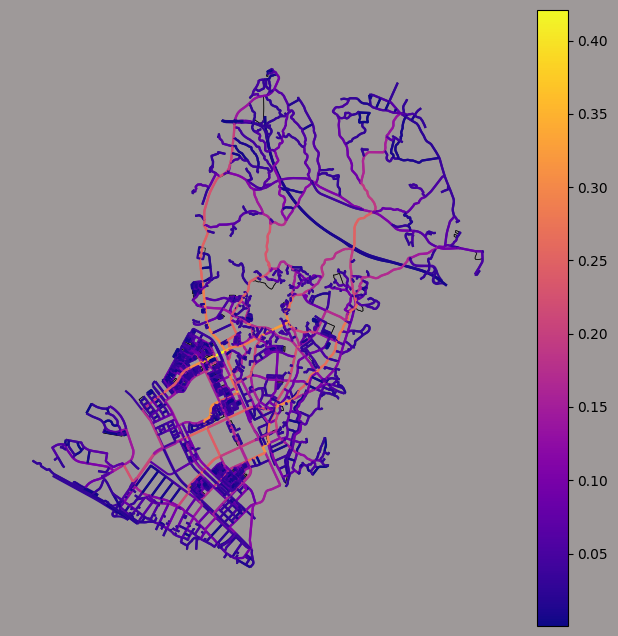

In [ ]:

# 시각화를 위해 루트처리
edges_gdf["bw_sqrt"] = np.sqrt(edges_gdf["edge_bw"])

# 6) 플롯
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.patch.set_facecolor("#9E9999")   # figure 배경
ax.set_facecolor("#111111")          # axis 배경
# (1) 전체 도로망을 연한 회색으로 먼저 그림 (배경)
edges_gdf.plot(
    ax=ax,
    color="black",
    linewidth=0.5,
    alpha=0.8
)

# (2) betweenness가 있는 edge만 색칠
edges_gdf.loc[edges_gdf["bw_sqrt"] > 0].plot(
    ax=ax,
    column="bw_sqrt",
    cmap="plasma",
    linewidth=1.6,
    legend=True,
    zorder=2
)

ax.set_axis_off()
#plt.tight_layout()
plt.show()

같은 방식 다른 지역으로 실험

In [96]:
# 1) 그래프 가져오기
place_name = "Nam-gu, Busan, South Korea"
G = ox.graph_from_place(place_name, network_type="drive")  # MultiDiGraph

# OSMnx는 기본적으로 edge['length']를 넣어줌 (추가 설정 필요 X)

# 2) edge betweenness 계산용 간단한 undirected 그래프 만들기
#    - parallel edge, 방향성은 일단 무시하고 구조만 보자
Gu = nx.Graph(G)   # MultiDiGraph -> simple Graph

# 3) edge betweenness 계산 (길이 기준)
bw_dict = nx.edge_betweenness_centrality(Gu, normalized=True, weight="length")
# bw_dict: {(u, v): 값}  (u, v)는 undirected라 (u, v) / (v, u) 동일 취급

# 4) 원래 G(MultiDiGraph)의 edge에 값 붙이기
for u, v, k, data in G.edges(keys=True, data=True):
    key = tuple(sorted((u, v)))  # undirected 키
    data["edge_bw"] = bw_dict.get(key, 0.0)

# 5) GeoDataFrame 변환
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# 혹시라도 없는 컬럼 체크 (디버깅용)
print(edges_gdf.columns)
print(edges_gdf["edge_bw"].describe())

Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'edge_bw',
       'geometry', 'lanes', 'ref', 'bridge', 'tunnel', 'maxspeed'],
      dtype='object')
count    4051.000000
mean        0.013431
std         0.023890
min         0.000000
25%         0.001336
50%         0.003520
75%         0.013240
max         0.169475
Name: edge_bw, dtype: float64


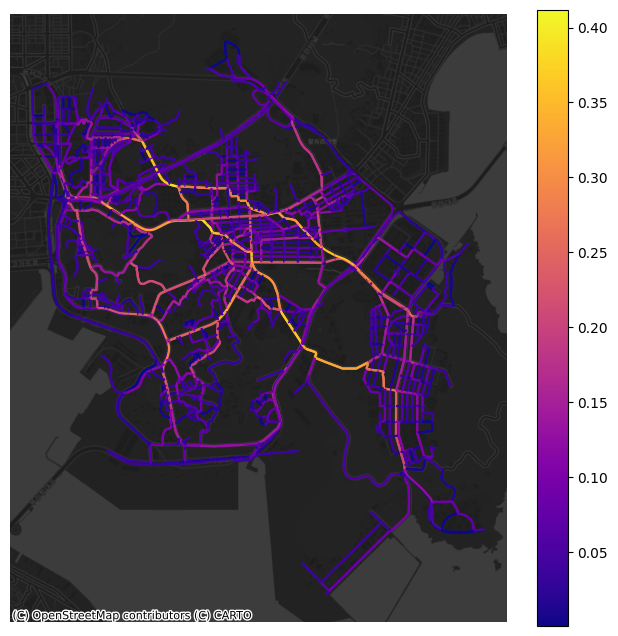

In [102]:
#좌표계 설정
edges_gdf = edges_gdf.to_crs(epsg=3857)
# 시각화를 위해 루트처리
fig.patch.set_facecolor("#9E9999") 
ax.set_facecolor("#111111")          
edges_gdf["bw_sqrt"] = np.sqrt(edges_gdf["edge_bw"])

# 6) 플롯
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# (2) betweenness가 있는 edge만 색칠
edges_gdf.loc[edges_gdf["bw_sqrt"] > 0].plot(
    ax=ax,
    column="bw_sqrt",
    cmap="plasma",
    linewidth=1.6,
    legend=True,
    zorder=2
)
# ✅ 실제 지도 배경
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatter,  # 어두운 배경
    alpha=0.9
)

ax.set_axis_off()
#plt.tight_layout()
plt.show()